# Patient Like Me - End to End

In [3]:
# !pip install "sagemaker>=2.140.0" "transformers==4.26.1" "datasets[s3]==2.10.1" --upgrade
# !pip install git+https://github.com/huggingface/transformers.git

# !pip install transformers datasets[s3] sagemaker --upgrade
# !pip install scikit-learn
# !pip install accelerate==0.20.3
# !pip install fastprogress
# !pip install ollama
# !ollama pull llama3
# !pip install llama-index==0.10.32
# !pip install langchain
# !pip install langchain_community

In [4]:
import numpy as np
from sagemaker import get_execution_role
import boto3
import pandas as pd
from io import StringIO # Python 3.
from datasets import load_dataset,Dataset,DatasetDict,concatenate_datasets
from fastprogress.fastprogress import master_bar, progress_bar

import pickle
from transformers import DataCollatorWithPadding,AutoModelForSequenceClassification, Trainer, TrainingArguments,AutoTokenizer,AutoModel,AutoConfig
from transformers.modeling_outputs import TokenClassifierOutput
import torch
import torch.nn as nn
import pandas as pd
import json

import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from transformers import TextClassificationPipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pickle
from transformers import AdamW, get_scheduler
from datasets import load_metric
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm
from collections import Counter

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
bucket_name = 'chianglab-dataderivatives'
file_path = "mimic-iv-ed-2.2/text_repr.json"

s3 = boto3.resource('s3')
content_object = s3.Object(bucket_name, file_path)
file_content = content_object.get()['Body'].read().decode('utf-8')
json_content = json.loads(file_content)
df = pd.DataFrame(json_content).T

df['eddischarge'] = [1 if 'admitted' in s.lower() else 0 for s in df['eddischarge']] # admitted = 1, Home = 0
df['medrecon'] = df['medrecon'].fillna("The patient was previously not taking any medications.")
df['pyxis'] = df['pyxis'].fillna("The patient did not receive any medications.")
df['vitals'] = df['vitals'].fillna("The patient had no vitals recorded")
df['codes'] = df['codes'].fillna("The patient received no diagnostic codes")
df = df.drop("admission",axis=1)
df = df.drop("discharge",axis=1)
df = df.drop("eddischarge_category",axis=1)
df['ID'] = df.arrival.astype(str).str.split().str[1].replace(",", " ", regex=True).to_list()
df["patient_info"] = df["arrival"] + " " + df["triage"] + " " + df["medrecon"] + " " + df["vitals"] + " " + df["codes"] + " " + df["pyxis"]
df = df[[col for col in df.columns if col != 'eddischarge'] + ['eddischarge']] # rearrange column to the end
df

,arrival,triage,medrecon,vitals,codes,pyxis,ID,patient_info,eddischarge
33258284,"Patient 10000032, a 52 year old white female, ...","At triage: temperature was 98.4, pulse was 70....",The patient was previously taking the followin...,The patient had the following vitals: At 2180-...,The patient received the following diagnostic ...,The patient did not receive any medications.,10000032,"Patient 10000032, a 52 year old white female, ...",1
38112554,"Patient 10000032, a 52 year old white female, ...","At triage: temperature was 98.9, pulse was 88....",The patient was previously taking the followin...,The patient had the following vitals: At 2180-...,The patient received the following diagnostic ...,The patient received the following medications...,10000032,"Patient 10000032, a 52 year old white female, ...",1
35968195,"Patient 10000032, a 52 year old white female, ...","At triage: temperature was 99.4, pulse was 105...",The patient was previously taking the followin...,The patient had the following vitals: At 2180-...,The patient received the following diagnostic ...,The patient received the following medications...,10000032,"Patient 10000032, a 52 year old white female, ...",1
32952584,"Patient 10000032, a 52 year old white female, ...","At triage: temperature was 97.8, pulse was 87....",The patient was previously taking the followin...,The patient had the following vitals: At 2180-...,The patient received the following diagnostic ...,The patient received the following medications...,10000032,"Patient 10000032, a 52 year old white female, ...",0
39399961,"Patient 10000032, a 52 year old white female, ...","At triage: temperature was 98.7, pulse was 77....",The patient was previously taking the followin...,The patient had the following vitals: At 2180-...,The patient received the following diagnostic ...,The patient received the following medications...,10000032,"Patient 10000032, a 52 year old white female, ...",1
...,...,...,...,...,...,...,...,...,...
34149746,"Patient 19999784, a 57 year old black/african ...","At triage: temperature was 98.8, pulse was 92....",The patient was previously taking the followin...,The patient had the following vitals: At 2119-...,The patient received the following diagnostic ...,The patient received the following medications...,19999784,"Patient 19999784, a 57 year old black/african ...",1
35692999,"Patient 19999784, a 57 year old black/african ...","At triage: temperature was 98.6, pulse was 80....",The patient was previously not taking any medi...,The patient had the following vitals: At 2119-...,The patient received the following diagnostic ...,The patient did not receive any medications.,19999784,"Patient 19999784, a 57 year old black/african ...",1
32917002,"Patient 19999828, a 46 year old white female, ...","At triage: temperature was 96.6, pulse was 112...",The patient was previously taking the followin...,The patient had the following vitals: At 2149-...,The patient received the following diagnostic ...,The patient received the following medications...,19999828,"Patient 19999828, a 46 year old white female, ...",1
30712109,"Patient 19999828, a 46 year old white female, ...","At triage: temperature was 98.1, pulse was 83....",The patient was previously taking the followin...,The patient had the following vitals: At 2147-...,The patient received the following diagnostic ...,The patient received the following medications...,19999828,"Patient 19999828, a 46 year old white female, ...",1


In [6]:
df = df.drop("arrival",axis=1)
df = df.drop("triage",axis=1)
df = df.drop("medrecon",axis=1)
df = df.drop("vitals",axis=1)
df = df.drop("codes",axis=1)
df = df.drop("pyxis",axis=1)

# Main execution
from sklearn.model_selection import train_test_split

# Sample 100,000 rows from the original DataFrame
temp = df.sample(10000)

# KNN where we bootstrap a group of embeddings and get a more robust prediciton

In [28]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import torch
from collections import Counter
import warnings

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', message="A parameter name that contains `beta` will be renamed internally to `bias`")
warnings.filterwarnings('ignore', message="A parameter name that contains `gamma` will be renamed internally to `weight`")

def encode_texts(texts, tokenizer, model):
    model.eval()
    if torch.cuda.is_available():
        model.to('cuda')
    embeddings = []
    with torch.no_grad():
        for text in tqdm(texts):
            encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512, padding='max_length')
            if torch.cuda.is_available():
                encoded_input = {key: val.to('cuda') for key, val in encoded_input.items()}
            output = model(**encoded_input)
            cls_embedding = output.last_hidden_state[:, 0, :]
            embeddings.append(cls_embedding.cpu().numpy())
    return np.vstack(embeddings)

def knn(train_data, test_data, tokenizer, model, n_neighbors=5, n_bootstrap=1000):
    # Encode train and test data
    train_embeddings = encode_texts(train_data['patient_info'].tolist(), tokenizer, model)
    test_embeddings = encode_texts(test_data['patient_info'].tolist(), tokenizer, model)

    # Fit KNN
    knn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
    knn.fit(train_embeddings)

    # Predict using KNN for the test set
    distances, indices = knn.kneighbors(test_embeddings)

    # Aggregate predictions
    predictions = []
    for idx_array in tqdm(indices):
        nearest_labels = train_data.iloc[idx_array]['eddischarge'].tolist()
        label_counts = Counter(nearest_labels)
        total = sum(label_counts.values())
        prob_positive = label_counts[1] / total  # Assuming 1 is the positive class
        predictions.append(prob_positive)

    # Compute metrics
    true_labels = test_data['eddischarge'].tolist()
    auroc_scores = []
    auprc_scores = []
    f1_scores = []

    # Bootstrap for confidence intervals
    for _ in tqdm(range(n_bootstrap)):
        boot_indices = np.random.randint(0, len(predictions), len(predictions))
        boot_predictions = [predictions[i] for i in boot_indices]
        boot_true_labels = [true_labels[i] for i in boot_indices]
        
        auroc_scores.append(roc_auc_score(boot_true_labels, boot_predictions))
        auprc_scores.append(average_precision_score(boot_true_labels, boot_predictions))
        f1_scores.append(f1_score(boot_true_labels, [1 if p > 0.5 else 0 for p in boot_predictions], average='macro'))

    # Calculate mean and 95% confidence intervals
    auroc_mean, auroc_conf = np.mean(auroc_scores), (np.percentile(auroc_scores, 2.5), np.percentile(auroc_scores, 97.5))
    auprc_mean, auprc_conf = np.mean(auprc_scores), (np.percentile(auprc_scores, 2.5), np.percentile(auprc_scores, 97.5))
    f1_mean, f1_conf = np.mean(f1_scores), (np.percentile(f1_scores, 2.5), np.percentile(f1_scores, 97.5))

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    
    # Calculate Precision-Recall curve
    precision, recall, _ = precision_recall_curve(true_labels, predictions)

    # Plot ROC curve
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')

    # Plot Precision-Recall curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')

    plt.tight_layout()
    plt.show()

    return {
        "Predictions": predictions,
        "Metrics": {
            "AUROC": (auroc_mean, auroc_conf),
            "AUPRC": (auprc_mean, auprc_conf),
            "F1": (f1_mean, f1_conf)
        },
        "ROC": (fpr, tpr),
        "PRC": (precision, recall)
    }, true_labels, predictions

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

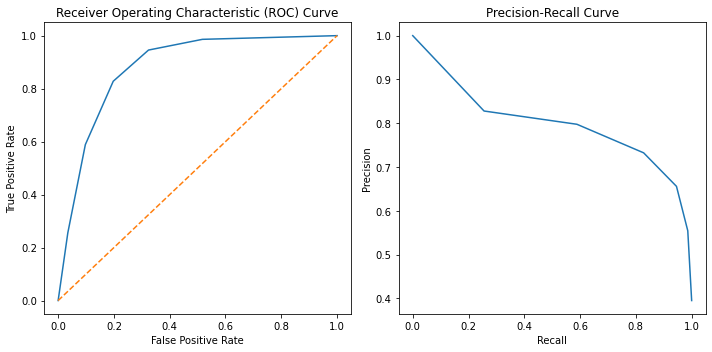

Predictions completed for test data.
AUROC: 0.88 (95% CI: 0.86-0.89)
AUPRC: 0.76 (95% CI: 0.73-0.79)
F1 Score: 0.81 (95% CI: 0.79-0.82)


In [29]:
# Split into train and test sets
train_set, test_set = train_test_split(temp, test_size=0.2, random_state=42)

# Initialize tokenizer and model once
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Call the knn function with both training and testing datasets
result, true, predicted = knn(train_data=train_set, test_data=test_set, tokenizer=tokenizer, model=model)

# Output the statistics
print("Predictions completed for test data.")
print("AUROC: {:.2f} (95% CI: {:.2f}-{:.2f})".format(result["Metrics"]["AUROC"][0], result["Metrics"]["AUROC"][1][0], result["Metrics"]["AUROC"][1][1]))
print("AUPRC: {:.2f} (95% CI: {:.2f}-{:.2f})".format(result["Metrics"]["AUPRC"][0], result["Metrics"]["AUPRC"][1][0], result["Metrics"]["AUPRC"][1][1]))
print("F1 Score: {:.2f} (95% CI: {:.2f}-{:.2f})".format(result["Metrics"]["F1"][0], result["Metrics"]["F1"][1][0], result["Metrics"]["F1"][1][1]))

100%|██████████| 1000/1000 [00:08<00:00, 124.33it/s]


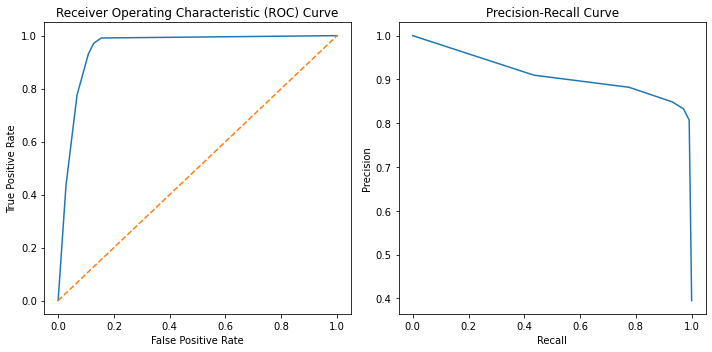

Predictions completed for test data.
AUROC: 0.95 (95% CI: 0.94-0.96)
AUPRC: 0.88 (95% CI: 0.86-0.90)
F1 Score: 0.90 (95% CI: 0.89-0.92)


In [31]:
# Main execution
from sklearn.model_selection import train_test_split

# Split into train and test sets
train_set, test_set = train_test_split(temp, test_size=0.2, random_state=42)

# Initialize tokenizer and model once
model_name = "medicalai/ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Call the knn function with both training and testing datasets
result_2, true_2, predicted_2 = knn(train_data=train_set, test_data=test_set, tokenizer=tokenizer, model=model)

# Output the statistics
print("Predictions completed for test data.")
print("AUROC: {:.2f} (95% CI: {:.2f}-{:.2f})".format(result_2["Metrics"]["AUROC"][0], result_2["Metrics"]["AUROC"][1][0], result_2["Metrics"]["AUROC"][1][1]))
print("AUPRC: {:.2f} (95% CI: {:.2f}-{:.2f})".format(result_2["Metrics"]["AUPRC"][0], result_2["Metrics"]["AUPRC"][1][0], result_2["Metrics"]["AUPRC"][1][1]))
print("F1 Score: {:.2f} (95% CI: {:.2f}-{:.2f})".format(result_2["Metrics"]["F1"][0], result_2["Metrics"]["F1"][1][0], result_2["Metrics"]["F1"][1][1]))

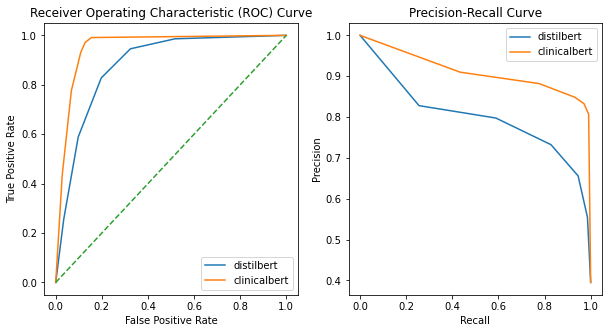

In [34]:
# distilbert
fpr, tpr, _ = roc_curve(true, predicted)
precision, recall, _ = precision_recall_curve(true, predicted)

# clinicalbert
fpr2, tpr2, _ = roc_curve(true_2, predicted_2)
precision2, recall2, _ = precision_recall_curve(true_2, predicted_2)

# Plot ROC curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label="distilbert")
plt.plot(fpr2, tpr2, label="clinicalbert")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

# Plot Precision-Recall curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label="distilbert")
plt.plot(recall2, precision2, label="clinicalbert")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.legend()

# one sample

In [24]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def knn(query_text, data_source, model_name, n_neighbors=5, sample_size=1000):
    # Bootstrap a dataframe
    df = pd.DataFrame(data_source)
    
    # Encode the text
    def encode_texts(model_name, texts):
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name)
        model.eval()
        if torch.cuda.is_available():
            model.to('cuda')
        embeddings = []
        with torch.no_grad():
            for text in tqdm(texts):
                encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512, padding='max_length')
                if torch.cuda.is_available():
                    encoded_input = {key: val.to('cuda') for key, val in encoded_input.items()}
                output = model(**encoded_input)
                cls_embedding = output.last_hidden_state[:, 0, :]
                embeddings.append(cls_embedding.cpu().numpy())
        print("Embeddings are generated")
        return np.vstack(embeddings)

    # Encode all text data
    all_embeddings = encode_texts(model_name, df['patient_info'].tolist())
    
    # Encode the query text
    query_embedding = encode_texts(model_name, [query_text])

    # Sample indices
    sample_indices = np.random.choice(len(df), size=sample_size, replace=False)
    
    # Get sample data
    sample_embeddings = all_embeddings[sample_indices]
    sample_df = df.iloc[sample_indices]

    # Build KNN embedding space
    knn = NearestNeighbors(n_neighbors=len(sample_embeddings), metric='cosine')
    knn.fit(sample_embeddings)
    
    # Query KNN
    distances, indices = knn.kneighbors(query_embedding)
    
    # Convert distances to similarities
    similarities = 1 - distances.flatten()

    # Plot the distribution of similarities
    plt.figure(figsize=(10, 6))
    sns.histplot(similarities, kde=True)
    plt.title('Distribution of Cosine Similarities')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.show()

    return similarities

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Embeddings are generated


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Embeddings are generated


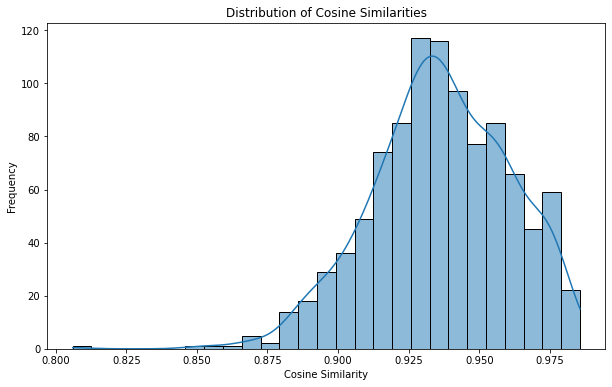

In [25]:
query_text = df["patient_info"].iloc[0]
data_source = temp
model_name = "bert-base-uncased"
similarities = knn(query_text, data_source, model_name)
# print(f"Predicted eddischarge: {prediction}")
# print(f"Ground Truth: {df['eddischarge'].iloc[0]}")

100%|██████████| 10000/10000 [02:48<00:00, 59.24it/s]


Embeddings are generated


100%|██████████| 1/1 [00:00<00:00, 68.54it/s]


Embeddings are generated


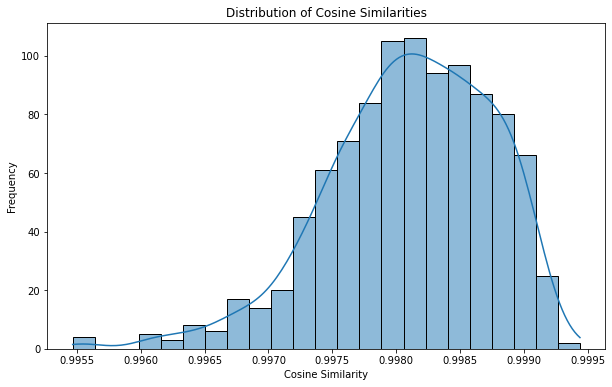

In [26]:
query_text = df["patient_info"].iloc[0]
data_source = temp
model_name = "medicalai/ClinicalBERT"
prediction = knn(query_text, data_source, model_name)
# print(f"Predicted eddischarge: {prediction}")
# print(f"Ground Truth: {df['eddischarge'].iloc[0]}")

# KNN where we return the results table

In [44]:
def query_knn_embeddings(query_text, data_source, model_name, n_neighbors=5):
    # Bootstrap a dataframe
    df = pd.DataFrame(data_source)

    # Encode the text
    def encode_texts(model_name, texts):
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name)
        model.eval()
        if torch.cuda.is_available():
            model.to('cuda')
        embeddings = []
        with torch.no_grad():
            for text in tqdm(texts):
                encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512, padding='max_length')
                if torch.cuda.is_available():
                    encoded_input = {key: val.to('cuda') for key, val in encoded_input.items()}
                output = model(**encoded_input)
                cls_embedding = output.last_hidden_state[:, 0, :]
                embeddings.append(cls_embedding.cpu().numpy())
        print("embeddings are generated")
        return np.vstack(embeddings)
    # Assume the text column is named 'patient_info'. Adjust if necessary.
    text_embeddings = encode_texts(model_name, df['patient_info'].tolist())

    # Build KNN embedding space
    knn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
    knn.fit(text_embeddings)

    # Encode the query text
    query_embedding = encode_texts(model_name, [query_text])

    # Query KNN
    distances, indices = knn.kneighbors(query_embedding)

    # Get results
    results = df.iloc[indices[0]]
    results['distance'] = distances[0]

    # Make prediction based on majority vote
    neighbor_labels = results['eddischarge'].tolist()
    prediction = Counter(neighbor_labels).most_common(1)[0][0]

    return results, prediction

In [38]:
# Example
query_text = df["patient_info"].iloc[0]
data_source = temp
model_name = "bert-base-uncased" # or any other model name
results, prediction = query_knn_embeddings(query_text, data_source, model_name)
print(results)
print("-------")
print(f"Predicted eddischarge: {prediction}")


100%|██████████| 1000/1000 [00:12<00:00, 80.19it/s]


embeddings are generated


100%|██████████| 1/1 [00:00<00:00, 77.90it/s]

embeddings are generated
                 ID                                       patient_info  \
32394613  18125751   Patient 18125751, a 57 year old white female, ...   
34022538  14187451   Patient 14187451, a 53 year old black/african ...   
35671330  18242530   Patient 18242530, a 76 year old white female, ...   
37661549  14062869   Patient 14062869, a 41 year old white female, ...   
32129835  12019283   Patient 12019283, a 25 year old black/african ...   

          eddischarge  distance  
32394613            0  0.013725  
34022538            1  0.016040  
35671330            0  0.016175  
37661549            0  0.016219  
32129835            0  0.017117  
-------
Predicted eddischarge: 0
Ground Truth: 1



<ipython-input-38-e356481266bc>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['distance'] = distances[0]


In [39]:
query_text = df["patient_info"].iloc[0]
data_source = temp
model_name = "medicalai/ClinicalBERT" 
results, prediction = query_knn_embeddings(query_text, data_source, model_name)
print(results)
print("-------")
print(f"Predicted eddischarge: {prediction}")
print(f"Ground Truth: {df['eddischarge'].iloc[0]}")

100%|██████████| 1000/1000 [00:07<00:00, 141.10it/s]


embeddings are generated


100%|██████████| 1/1 [00:00<00:00, 134.61it/s]

embeddings are generated
                 ID                                       patient_info  \
36599058  16315929   Patient 16315929, a 62 year old white female, ...   
32576195  13374041   Patient 13374041, a 58 year old white female, ...   
33509281  10018862   Patient 10018862, a 56 year old white female, ...   
31725842  18307993   Patient 18307993, a 45 year old black/african ...   
32638903  13471464   Patient 13471464, a 73 year old white female, ...   

          eddischarge  distance  
36599058            1  0.000650  
32576195            1  0.000689  
33509281            1  0.000711  
31725842            1  0.000743  
32638903            1  0.000770  
-------
Predicted eddischarge: 1
Ground Truth: 1



<ipython-input-38-e356481266bc>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['distance'] = distances[0]


# can we see what keywords are being highlighted by the similarity calculation

In [40]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def knn(query_text, data_source, model_name, n_neighbors=5, sample_size=1000):
    # Bootstrap a dataframe
    df = pd.DataFrame(data_source)
    
    # Encode the text
    def encode_texts(model_name, texts):
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name)
        model.eval()
        if torch.cuda.is_available():
            model.to('cuda')
        embeddings = []
        tokens_list = []
        with torch.no_grad():
            for text in tqdm(texts):
                encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512, padding='max_length')
                if torch.cuda.is_available():
                    encoded_input = {key: val.to('cuda') for key, val in encoded_input.items()}
                output = model(**encoded_input)
                cls_embedding = output.last_hidden_state[:, 0, :]
                embeddings.append(cls_embedding.cpu().numpy())
                tokens_list.append(tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0]))
        print("Embeddings are generated")
        return np.vstack(embeddings), tokens_list

    # Encode all text data
    all_embeddings, all_tokens = encode_texts(model_name, df['patient_info'].tolist())
    
    # Encode the query text
    query_embedding, query_tokens = encode_texts(model_name, [query_text])

    # Sample indices
    sample_indices = np.random.choice(len(df), size=sample_size, replace=False)
    
    # Get sample data
    sample_embeddings = all_embeddings[sample_indices]
    sample_df = df.iloc[sample_indices]
    sample_tokens = [all_tokens[i] for i in sample_indices]

    # Build KNN embedding space
    knn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
    knn.fit(sample_embeddings)
    
    # Query KNN
    distances, indices = knn.kneighbors(query_embedding)
    
    # Convert distances to similarities
    similarities = 1 - distances.flatten()

    # Analyze token importance
    def get_token_importance(query_emb, sample_emb, query_tokens, sample_tokens):
        dot_product = np.dot(query_emb, sample_emb.T)
        query_norm = np.linalg.norm(query_emb)
        sample_norm = np.linalg.norm(sample_emb)
        cosine_sim = dot_product / (query_norm * sample_norm)
        
        token_importance = cosine_sim * query_emb * sample_emb
        token_importance = token_importance / np.sum(np.abs(token_importance))
        
        important_tokens = sorted(zip(query_tokens[0], sample_tokens, token_importance[0]), 
                                  key=lambda x: abs(x[2]), reverse=True)[:10]
        return important_tokens

    # Get important tokens for top 5 nearest neighbors
    top_neighbors = indices[0][:5]
    important_tokens_list = []
    for idx in top_neighbors:
        important_tokens = get_token_importance(query_embedding, sample_embeddings[idx], 
                                                query_tokens, sample_tokens[idx])
        important_tokens_list.append(important_tokens)

    return similarities, important_tokens_list

In [41]:
query_text = df["patient_info"].iloc[0]
data_source = temp
model_name = "medicalai/ClinicalBERT"
similarities, important_tokens_list = knn(query_text, data_source, model_name)

# Print important tokens for top 5 nearest neighbors
for i, tokens in enumerate(important_tokens_list):
    print(f"Important tokens for neighbor {i+1}:")
    for query_token, sample_token, importance in tokens:
        print(f"  Query: {query_token}, Sample: {sample_token}, Importance: {importance:.4f}")
    print()

100%|██████████| 10000/10000 [03:22<00:00, 49.45it/s]


Embeddings are generated


100%|██████████| 1/1 [00:00<00:00, 52.20it/s]

Embeddings are generated
Important tokens for neighbor 1:
  Query: pressure, Sample: 0, Importance: 0.0851
  Query: ##ic, Sample: ##ic, Importance: 0.0669
  Query: sp, Sample: ##tives, Importance: 0.0297
  Query: acu, Sample: ab, Importance: 0.0285
  Query: 0, Sample: ##ic, Importance: 0.0265
  Query: satu, Sample: ., Importance: 0.0242
  Query: ##ic, Sample: 77, Importance: 0.0238
  Query: ##d, Sample: :, Importance: 0.0229
  Query: dis, Sample: med, Importance: 0.0220
  Query: ##tero, Sample: gi, Importance: 0.0214

Important tokens for neighbor 2:
  Query: pressure, Sample: ., Importance: 0.0852
  Query: ##ic, Sample: ., Importance: 0.0668
  Query: sp, Sample: (, Importance: 0.0299
  Query: acu, Sample: acu, Importance: 0.0284
  Query: 0, Sample: ##intes, Importance: 0.0265
  Query: satu, Sample: ##9, Importance: 0.0244
  Query: ##ic, Sample: [, Importance: 0.0244
  Query: ##d, Sample: ##2, Importance: 0.0231
  Query: dis, Sample: 401, Importance: 0.0219
  Query: ##tero, Sample: blo

In [7]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def knn_heatmap(query_text, data_source, model_name, n_neighbors=5, sample_size=1000, n_clusters=5):
    # Bootstrap a dataframe
    df = pd.DataFrame(data_source)
    
    # Encode the text
    def encode_texts(model_name, texts):
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name)
        model.eval()
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model.to(device)
        embeddings = []
        with torch.no_grad():
            for text in tqdm(texts):
                encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512, padding='max_length')
                encoded_input = {key: val.to(device) for key, val in encoded_input.items()}
                output = model(**encoded_input)
                cls_embedding = output.last_hidden_state[:, 0, :]
                embeddings.append(cls_embedding.cpu().numpy())
        print("Embeddings are generated")
        return np.vstack(embeddings)

    # Encode all text data
    all_embeddings = encode_texts(model_name, df['patient_info'].tolist())
    
    # Encode the query text
    query_embedding = encode_texts(model_name, [query_text])

    # Sample indices
    sample_indices = np.random.choice(len(df), size=sample_size, replace=False)
    
    # Get sample data
    sample_embeddings = all_embeddings[sample_indices]
    sample_df = df.iloc[sample_indices]

    # Build KNN embedding space
    knn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
    knn.fit(sample_embeddings)
    
    # Query KNN
    distances, indices = knn.kneighbors(query_embedding)
    
    # Convert distances to similarities
    similarity_matrix = 1 - pairwise_distances(sample_embeddings, metric='cosine')

    # Perform hierarchical clustering
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clustering.fit_predict(sample_embeddings)

    # Sort indices based on cluster labels
    sorted_indices = np.argsort(cluster_labels)

    # Reorder similarity matrix
    reordered_similarity_matrix = similarity_matrix[sorted_indices][:, sorted_indices]

    # Create heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(reordered_similarity_matrix, cmap='viridis')
    plt.title('Similarity Matrix Heatmap (Clustered)')
    plt.xlabel('Samples')
    plt.ylabel('Samples')
    plt.show()

    # Calculate similarities between query and samples
    query_similarities = 1 - pairwise_distances(query_embedding, sample_embeddings, metric='cosine')[0]

    # Extract important tokens
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    important_tokens_list = []
    for text in sample_df['patient_info']:
        tokens = tokenizer.tokenize(text)
        # Here we're simplistically considering the first 5 tokens as important
        # You might want to implement a more sophisticated method for token importance
        important_tokens = tokens[:5]
        important_tokens_list.append(important_tokens)

    return query_similarities, important_tokens_list

100%|██████████| 10000/10000 [01:12<00:00, 137.89it/s]


Embeddings are generated


100%|██████████| 1/1 [00:00<00:00, 126.46it/s]


Embeddings are generated


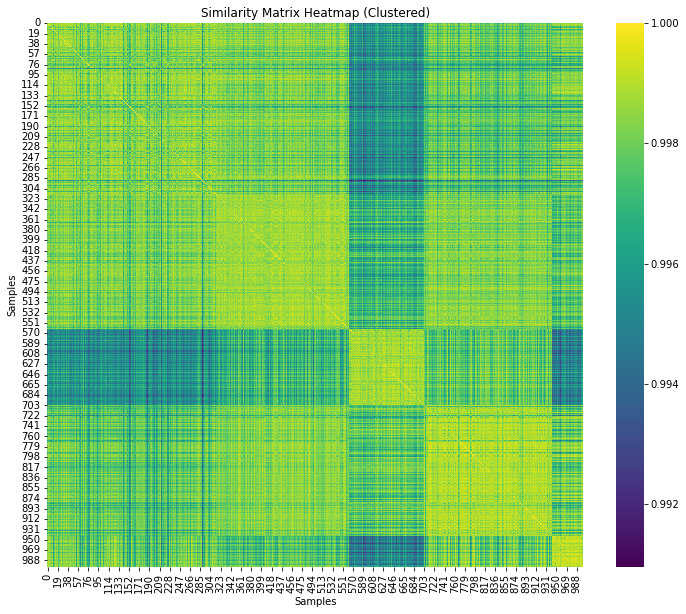

In [8]:
query_text = df["patient_info"].iloc[0]
data_source = temp
model_name = "medicalai/ClinicalBERT"
similarities, important_tokens_list = knn_heatmap(query_text, data_source, model_name)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Embeddings are generated


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Embeddings are generated


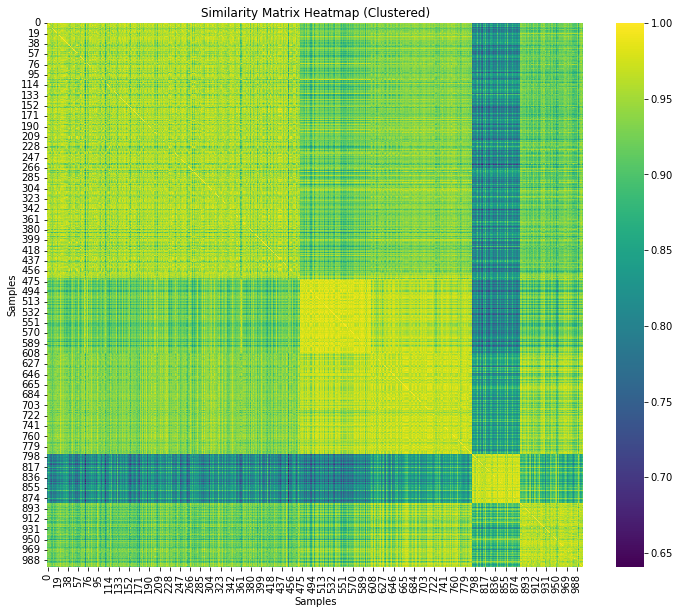

Token indices sequence length is longer than the specified maximum sequence length for this model (847 > 512). Running this sequence through the model will result in indexing errors


In [9]:
query_text = df["patient_info"].iloc[0]
data_source = temp
model_name = "bert-base-uncased"
similarities, important_tokens_list = knn_heatmap(query_text, data_source, model_name)